In [47]:

#!pip install helical --use-pep517

#!pip install datasets --upgrade

In [48]:

from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import anndata as ad
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch import nn
from scipy.sparse import lil_matrix
import torch.optim as optim
from helical.models.scgpt.model import scGPT, scGPTConfig
from helical.models.geneformer.model import Geneformer, GeneformerConfig
from copy import deepcopy
from torch.nn.functional import one_hot
import torch
print(torch.__version__)  # Should print a version like 2.0.1+cu118 or 2.1.0+cu121
print(torch.version.cuda)  # Should print the CUDA version (e.g., 11.8 or 12.1)
print(torch.cuda.is_available()) 

2.5.1+cu118
11.8
True


In [49]:
from datasets import load_dataset
ds = load_dataset("helical-ai/yolksac_human",trust_remote_code=True, split="train[:65%]",download_mode="reuse_cache_if_exists")

Generating test split: 100%|██████████| 6336/6336 [00:04<00:00, 1331.75 examples/s]


In [50]:
observation_columns = [obs for obs in list(ds.features.keys()) if not obs == 'raw_counts']
obs_data = pd.DataFrame(ds.select_columns(observation_columns).data.to_pandas(),columns=observation_columns)
lil = lil_matrix((len(ds),ds[0]['size']))
lil.data = np.array(ds['raw_counts'],dtype="object")
lil.rows = np.array(ds['rows'],dtype="object")
adata = ad.AnnData(lil.tocsr(),obs=obs_data)
adata.var_names = ds.features['raw_counts'].id.split(",")
adata.var['gene_name'] = adata.var_names.str.upper()

In [51]:
# get labels: the celltype
num_types = adata.obs["LVL1"].unique().shape[0]
id2type = dict(enumerate(adata.obs["LVL1"].astype("category").cat.categories))

celltypes_labels = np.array(adata.obs["LVL1"].tolist())

In [52]:
device = "cuda" if torch.cuda.is_available() else "cpu"
scgpt_config = scGPTConfig(batch_size=50, device=device)
scgpt = scGPT(configurer = scgpt_config)
data = scgpt.process_data(adata, gene_names = "gene_name")
x_original = scgpt.get_embeddings(data)
print(np.argmax(np.sum(x_original,axis=0)))

INFO:helical.utils.downloader:File: 'C:\Users\tomjo\.cache\helical\models\scgpt/scGPT_CP/vocab.json' exists already. File is not overwritten and nothing is downloaded.
INFO:helical.utils.downloader:File saved to: 'C:\Users\tomjo\.cache\helical\models\scgpt/scGPT_CP/vocab.json'
INFO:helical.utils.downloader:File: 'C:\Users\tomjo\.cache\helical\models\scgpt/scGPT_CP/best_model.pt' exists already. File is not overwritten and nothing is downloaded.
INFO:helical.utils.downloader:File saved to: 'C:\Users\tomjo\.cache\helical\models\scgpt/scGPT_CP/best_model.pt'
INFO:helical.models.scgpt.model:Model finished initializing.
INFO:helical.models.scgpt.model:Filtering out 11163 genes to a total of 26155 genes with an id in the scGPT vocabulary.
INFO:helical.models.scgpt.model:Inference started:
Embedding cells: 100%|██████████| 330/330 [03:29<00:00,  1.57it/s]

260


In [53]:
print(np.argmax(np.sum(x_original,axis=1)))

9950


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
scgpt_config = scGPTConfig(batch_size=50, device=device)
scgpt = scGPT(configurer = scgpt_config)
#print(load_model(scgpt_config)[1])


def knockout_genes(data,model,genes):
  """ Generate embeddings for the original dataset and modified dataset using
  the selected model. The modified dataset has gene expressions set to 0 for
  all genes present in the genes list.

  Inputs:
      data (anndata): An anndata file with single-cell expression data
      model : A pre-trained foundation model (e.g., scGPT, Geneformer)
      genes (list of integers): Each integer corresponds to the index of the gene that is being knocked out in the adata.var list

  Outputs:
      x_model : embeddings for orginal data (no dropout)
      x_model_dropped : embeddings for data with genes knockout out                    
  """
  # generate embeddings on original data
  original_data = data.copy()
  new_data1 = model.process_data(adata = original_data, gene_names = "gene_name")
  x_model = model.get_embeddings(new_data1)
  
  # Knockout: update data in a vectorised way all at once to reduce memory spike
  perturbed_data = data.copy()
  perturbed_data.X[:,genes] = 0 
  new_data = model.process_data(adata = perturbed_data, gene_names = "gene_name")
  x_model_dropped = model.get_embeddings(new_data)
  
  # check which genes are not chosen by the model
  print([i for i in genes if data.var["gene_name"][i] not in new_data.vocab])

  return x_model, x_model_dropped

genes_to_knockout = [9950]
x_modelt, x_model_droppedt = knockout_genes(adata,scgpt,genes_to_knockout)


INFO:helical.utils.downloader:File: 'C:\Users\tomjo\.cache\helical\models\scgpt/scGPT_CP/vocab.json' exists already. File is not overwritten and nothing is downloaded.
INFO:helical.utils.downloader:File saved to: 'C:\Users\tomjo\.cache\helical\models\scgpt/scGPT_CP/vocab.json'
INFO:helical.utils.downloader:File: 'C:\Users\tomjo\.cache\helical\models\scgpt/scGPT_CP/best_model.pt' exists already. File is not overwritten and nothing is downloaded.
INFO:helical.utils.downloader:File saved to: 'C:\Users\tomjo\.cache\helical\models\scgpt/scGPT_CP/best_model.pt'
INFO:helical.models.scgpt.model:Model finished initializing.
INFO:helical.models.scgpt.model:Filtering out 11163 genes to a total of 26155 genes with an id in the scGPT vocabulary.
INFO:helical.models.scgpt.model:Inference started:


  (0, 3)	2.0
  (0, 26)	1.0
  (0, 41)	3.0
  (0, 55)	1.0
  (0, 67)	2.0
  (0, 68)	4.0
  (0, 69)	2.0
  (0, 72)	2.0
  (0, 91)	1.0
  (0, 98)	2.0
  (0, 110)	1.0
  (0, 119)	1.0
  (0, 120)	1.0
  (0, 129)	1.0
  (0, 188)	1.0
  (0, 348)	2.0
  (0, 437)	1.0
  (0, 488)	1.0
  (0, 497)	1.0
  (0, 519)	1.0
  (0, 634)	1.0
  (0, 904)	1.0
  (0, 957)	1.0
  (0, 1311)	1.0
  (0, 1572)	1.0
  :	:
  (40, 35704)	1.0
  (40, 35730)	1.0
  (40, 35743)	1.0
  (40, 35798)	1.0
  (40, 35807)	1.0
  (40, 35812)	1.0
  (40, 35850)	1.0
  (40, 35860)	1.0
  (40, 35888)	1.0
  (40, 36098)	1.0
  (40, 36156)	1.0
  (40, 36181)	1.0
  (40, 36276)	1.0
  (40, 36280)	1.0
  (40, 36319)	2.0
  (40, 36506)	1.0
  (40, 36557)	1.0
  (40, 36586)	1.0
  (40, 36588)	1.0
  (40, 36657)	1.0
  (40, 36905)	1.0
  (40, 37024)	1.0
  (40, 37054)	1.0
  (40, 37243)	1.0
  (40, 37306)	1.0


Embedding cells: 100%|██████████| 330/330 [09:16<00:00,  1.68s/it]
INFO:helical.models.scgpt.model:Filtering out 11163 genes to a total of 26155 genes with an id in the scGPT vocabulary.
INFO:helical.models.scgpt.model:Inference started:


[]


Embedding cells: 100%|██████████| 330/330 [06:08<00:00,  1.12s/it]


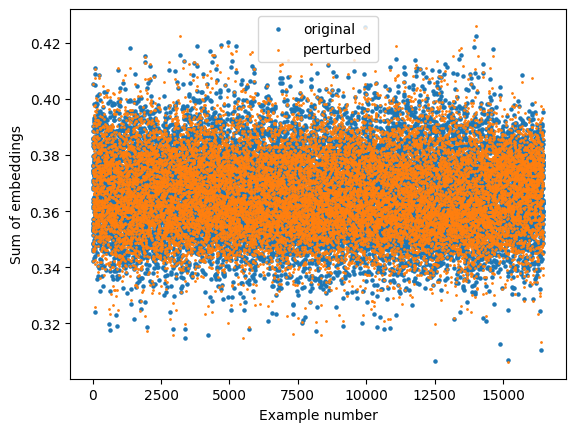

2708
[ True  True  True ... False False False]


In [169]:
import matplotlib.pyplot as plt
i=200
plt.figure()
#plt.scatter(list(range(len(x_modelt[:,0]))), np.sum(x_modelt,axis=1), label="original",s=5)
plt.scatter(list(range(len(x_modelt[:,0]))), np.sum(x_modelt,axis=1), label="original",s=5)
plt.scatter(list(range(len(x_modelt[:,0]))), np.sum(x_model_droppedt,axis=1), label="perturbed",s=1)
plt.legend()
plt.xlabel("Example number")
plt.ylabel("Sum of embeddings")
plt.show()
error = 0
index = 0
x = np.sum(x_modelt,axis=1)
y = np.sum(x_model_droppedt,axis=1)
for i in range(len(x_modelt[:,0])):
    squared_error = (x[i]-y[i])**2
    if squared_error > error:
        index=i
        error = squared_error
print(index)
print(x_modelt[:,0]==x_model_droppedt[:,0])

In [209]:
mse = (abs(x_modelt - x_model_droppedt)).mean(axis=None)
print(mse)
mse = (abs(x_model - x_model_dropped)).mean(axis=None)
print(mse)
print(np.argmax(np.sum(x_model,axis=1)))
print(np.argmax(np.sum(x_model_dropped,axis=1)))

0.0047292546
0.00865746
9950
9950


In [206]:
print(np.mean(abs(x_model)))
print(np.mean(abs(x_model_dropped)))
print(np.mean(abs(x_model_droppedt)))
print(x_model)

0.025624005
0.026349416
0.025614448
[[-0.02136835  0.06865783  0.00429632 ... -0.01800651 -0.04763141
  -0.00648617]
 [ 0.0117291  -0.01243525  0.01495861 ... -0.00948205 -0.00610439
  -0.02113074]
 [-0.008802    0.00062313  0.01009655 ... -0.02800423 -0.0361117
  -0.00064575]
 ...
 [ 0.00134418 -0.02546209  0.04644077 ... -0.05818865 -0.00955993
   0.00677072]
 [ 0.01920676 -0.04812495  0.02700905 ... -0.03192747 -0.01421586
  -0.0227727 ]
 [ 0.02803278 -0.0315269   0.03356605 ... -0.02524916  0.01734433
   0.00606563]]


In [170]:
print(9950 in adata.obs["rows"][2708])

False


In this cell example almost all of the genes that have been knocked out are present, so the fact that this example has changed by the largest amount in importance is to be expected.

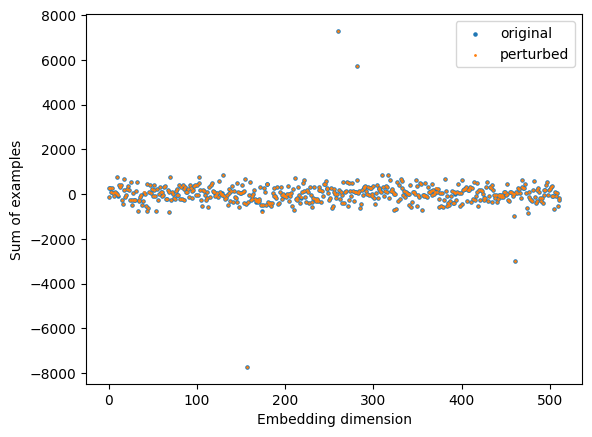

In [171]:
import matplotlib.pyplot as plt
i=200
plt.figure()
plt.scatter(list(range(len(x_modelt[0]))), np.sum(x_modelt,axis=0), label="original",s=5)
plt.scatter(list(range(len(x_modelt[0]))), np.sum(x_model_droppedt,axis=0), label="perturbed",s=1)
plt.legend()
plt.xlabel("Embedding dimension")
plt.ylabel("Sum of examples")
plt.show()


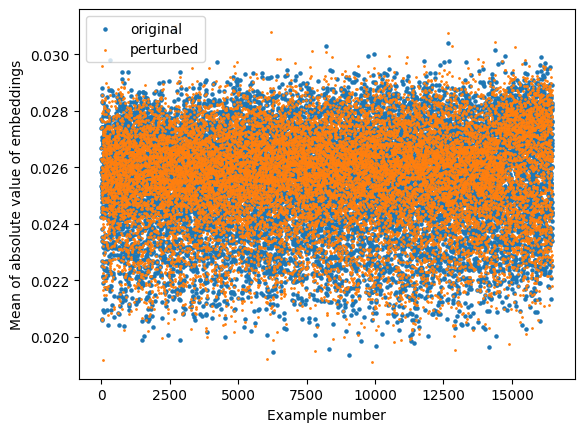

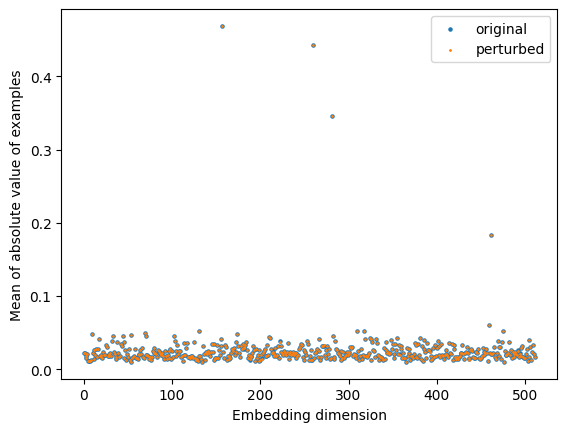

In [215]:
plt.scatter(list(range(len(x_modelt[:,0]))), np.mean(abs(x_modelt),axis=1), label="original",s=5)
plt.scatter(list(range(len(x_modelt[:,0]))), np.mean(abs(x_model_droppedt),axis=1), label="perturbed",s=1)
plt.legend()
plt.xlabel("Example number")
plt.ylabel("Mean of absolute value of embeddings")
plt.show()
plt.figure()
plt.scatter(list(range(len(x_modelt[0]))), np.mean(abs(x_modelt),axis=0), label="original",s=5)
plt.scatter(list(range(len(x_modelt[0]))), np.mean(abs(x_model_droppedt),axis=0), label="perturbed",s=1)
plt.legend()
plt.xlabel("Embedding dimension")
plt.ylabel("Mean of absolute value of examples")
plt.show()

In [ ]:
num_types = adata.obs["LVL1"].unique().shape[0]
id2type = dict(enumerate(adata.obs["LVL1"].astype("category").cat.categories))
celltypes_labels = np.array(adata.obs["LVL1"].tolist())


In order to investigate which genes the model relies on the most let's first look at how many examples of each of the 6 cell types we have. The cell type with the fewest examples will have the least exposure to many examples containing different genes so is a good place to look for genes that are important to the model.

In [58]:
num_types = adata.obs["LVL1"].unique().shape[0]
id2type = dict(enumerate(adata.obs["LVL1"].astype("category").cat.categories))
celltypes_labels = np.array(adata.obs["LVL1"].tolist())
labels = adata.obs["LVL1"].unique()
print(labels)
for i in range(6):
    #print(f"{labels[i]} has {len(adata[adata.obs["LVL1"]==labels[i]])} datapoints")
    print(labels[i],len(adata[adata.obs["LVL1"]==labels[i]]))

lymphoid_data = adata[adata.obs["LVL1"]==labels[5]]
# store frequency of genes in a list where index corresponds to gene_index shown in row
gene_list = np.zeros(len(adata.var))
for x in lymphoid_data.obs['rows']:
    for gene in x:
        gene_list[gene] += 1

print(np.where(gene_list==29.0)[0])
knockout = np.where(gene_list==29.0)[0]
print(len(knockout))
# convert indices to gene names
#knockout = adata.var_names[knockout]
x_model, x_model_dropped = knockout_genes(adata,scgpt,knockout)

['STROMA' 'ERYTHROID' 'MYELOID' 'MK' 'PROGENITOR' 'LYMPHOID']
STROMA 7824
ERYTHROID 3468
MYELOID 4888
MK 118
PROGENITOR 147
LYMPHOID 29
[ 5881  5883  9558  9788  9802  9902 10281 10975 11895 11968 12217 12525
 12538 13775 14048 14731 14739 14740 14742 14743 14824 14883 14994 15725
 16226 16227 16300 16379 16405 16720 16962 17219 17263 17264 17510 17653
 17682 17695 17858 17876 19349 22522 22524 22525 22526 22527 22531 22532
 22533 22723 22728 22829 23015 23037 23415 23682 23907 23995 24184 24328
 24484 24494 25142 25568 25613 25688 25941 25944 31320 31321 31323 31324
 31325 31326 31327 31328 31329 31331 31332 31333 31334 31335 31338 31340
 31341 31344 31346 31347 31348 31349 31350 31351 31352 31355 31356 31357
 31358 31361 31362 31363 31364 31367 31368 31369 31370 31371 31372 31374
 31375 31376 31377 31378 31398 31399 31400 31401 31402 31403 31404 31405
 31406 31407 31409 31411 31412 31413 31414 31415 31416 31417 31419 31421
 31422 31423 31426 31427 31441 31442 31443 31444 31968 32020 

INFO:helical.models.scgpt.model:Filtering out 11163 genes to a total of 26155 genes with an id in the scGPT vocabulary.
INFO:helical.models.scgpt.model:Inference started:


  (0, 3)	2.0
  (0, 26)	1.0
  (0, 41)	3.0
  (0, 55)	1.0
  (0, 67)	2.0
  (0, 68)	4.0
  (0, 69)	2.0
  (0, 72)	2.0
  (0, 91)	1.0
  (0, 98)	2.0
  (0, 110)	1.0
  (0, 119)	1.0
  (0, 120)	1.0
  (0, 129)	1.0
  (0, 188)	1.0
  (0, 348)	2.0
  (0, 437)	1.0
  (0, 488)	1.0
  (0, 497)	1.0
  (0, 519)	1.0
  (0, 634)	1.0
  (0, 904)	1.0
  (0, 957)	1.0
  (0, 1311)	1.0
  (0, 1572)	1.0
  :	:
  (40, 35704)	1.0
  (40, 35730)	1.0
  (40, 35743)	1.0
  (40, 35798)	1.0
  (40, 35807)	1.0
  (40, 35812)	1.0
  (40, 35850)	1.0
  (40, 35860)	1.0
  (40, 35888)	1.0
  (40, 36098)	1.0
  (40, 36156)	1.0
  (40, 36181)	1.0
  (40, 36276)	1.0
  (40, 36280)	1.0
  (40, 36319)	2.0
  (40, 36506)	1.0
  (40, 36557)	1.0
  (40, 36586)	1.0
  (40, 36588)	1.0
  (40, 36657)	1.0
  (40, 36905)	1.0
  (40, 37024)	1.0
  (40, 37054)	1.0
  (40, 37243)	1.0
  (40, 37306)	1.0


Embedding cells: 100%|██████████| 330/330 [03:41<00:00,  1.49it/s]
INFO:helical.models.scgpt.model:Filtering out 11163 genes to a total of 26155 genes with an id in the scGPT vocabulary.
INFO:helical.models.scgpt.model:Inference started:


[17219, 17263, 17264]


Embedding cells: 100%|██████████| 330/330 [14:46:18<00:00, 161.15s/it]      


In [187]:
lymphoid_data = adata[adata.obs["LVL1"]==labels[5]]
stroma_data = adata[adata.obs["LVL1"]==labels[0]]
ery_data = adata[adata.obs["LVL1"]==labels[1]]
mye_data = adata[adata.obs["LVL1"]==labels[2]]
mk_data = adata[adata.obs["LVL1"]==labels[3]]
pro_data = adata[adata.obs["LVL1"]==labels[4]]
# store frequency of genes in a list where index corresponds to gene_index shown in row
count_lym = 0
for x in lymphoid_data.obs['rows']:
    count_lym+=len(x)
avr_lym = count_lym/len(lymphoid_data)
count_stroma = 0
for x in stroma_data.obs['rows']:
    count_stroma+=len(x)
avr_stroma = count_stroma/len(stroma_data)
count_ery= 0
for x in ery_data.obs['rows']:
    count_ery+=len(x)
avr_ery = count_ery/len(ery_data)
count_mye = 0
for x in mye_data.obs['rows']:
    count_mye+=len(x)
avr_mye = count_mye/len(mye_data)
count_mk = 0
for x in mk_data.obs['rows']:
    count_mk+=len(x)
avr_mk = count_mk/len(mk_data)
count_pro = 0
for x in pro_data.obs['rows']:
    count_pro+=len(x)
avr_pro = count_pro/len(pro_data)
print(avr_lym,avr_stroma,avr_ery,avr_mye,avr_mk,avr_pro)

4047.103448275862 1798.8332055214723 1698.0305651672434 1677.712765957447 1873.2542372881355 4398.9795918367345


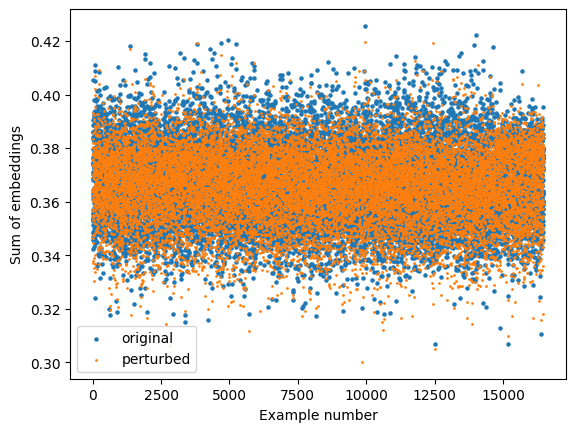

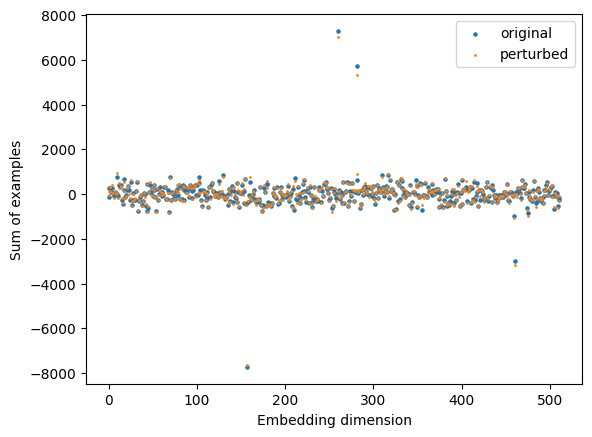

In [211]:
plt.figure()
#plt.scatter(list(range(len(x_modelt[:,0]))), np.sum(x_modelt,axis=1), label="original",s=5)
plt.scatter(list(range(len(x_modelt[:,0]))), np.sum(x_model,axis=1), label="original",s=5)
plt.scatter(list(range(len(x_modelt[:,0]))), np.sum(x_model_dropped,axis=1), label="perturbed",s=1)
plt.legend()
plt.xlabel("Example number")
plt.ylabel("Sum of embeddings")
plt.show()
plt.figure()
plt.scatter(list(range(len(x_modelt[0]))), np.sum(x_model,axis=0), label="original",s=5)
plt.scatter(list(range(len(x_modelt[0]))), np.sum(x_model_dropped,axis=0), label="perturbed",s=1)
plt.legend()
plt.xlabel("Embedding dimension")
plt.ylabel("Sum of examples")
plt.show()

In [227]:
perturbed_list = []
new_list = []
means = np.mean(abs(x_model_dropped),axis=1)
for i in range(len(x_model_dropped)):
    value = means[i]
    if i in list_of_examples:
        perturbed_list.append(value)
    else:
        new_list.append(value)
original_examples = [i for i in range(len(x_modelt[:,0])) if i not in list_of_examples]
print(len(original_examples))

15813


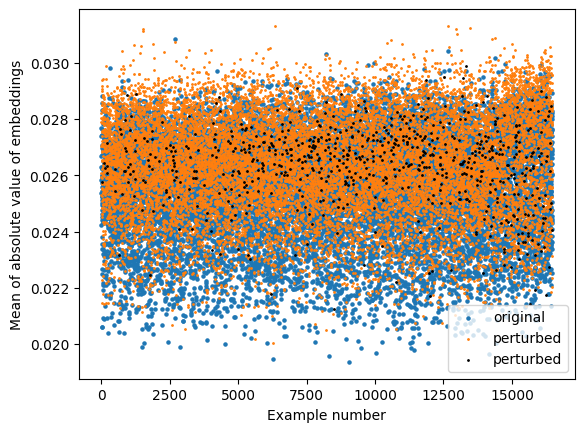

In [229]:
plt.scatter(list(range(len(x_modelt[:,0]))), np.mean(abs(x_model),axis=1), label="original",s=5)
#plt.scatter(list(range(len(x_modelt[:,0]))), np.mean(abs(x_model_dropped),axis=1), label="perturbed",s=1)
plt.scatter(original_examples, new_list, label="perturbed",s=1)
plt.scatter(list_of_examples, perturbed_list, label="perturbed",s=1, color = "black")
plt.legend()
plt.xlabel("Example number")
plt.ylabel("Mean of absolute value of embeddings")
plt.show()

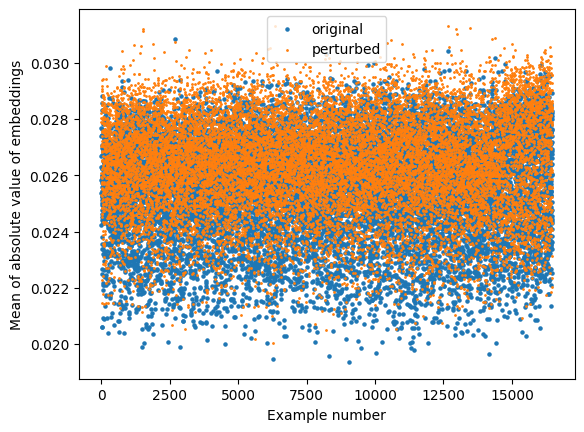

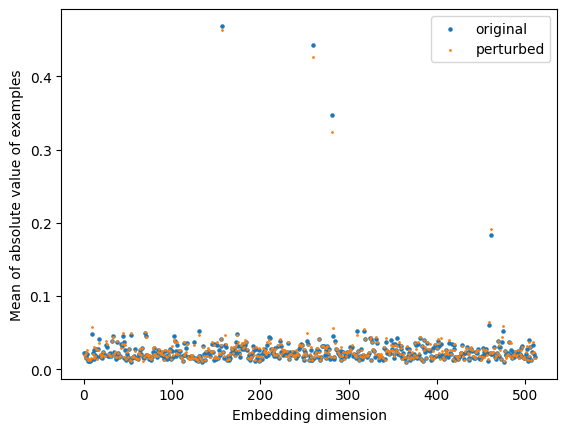

In [216]:
plt.scatter(list(range(len(x_modelt[:,0]))), np.mean(abs(x_model),axis=1), label="original",s=5)
plt.scatter(list(range(len(x_modelt[:,0]))), np.mean(abs(x_model_dropped),axis=1), label="perturbed",s=1)
plt.legend()
plt.xlabel("Example number")
plt.ylabel("Mean of absolute value of embeddings")
plt.show()
plt.figure()
plt.scatter(list(range(len(x_modelt[0]))), np.mean(abs(x_model),axis=0), label="original",s=5)
plt.scatter(list(range(len(x_modelt[0]))), np.mean(abs(x_model_dropped),axis=0), label="perturbed",s=1)
plt.legend()
plt.xlabel("Embedding dimension")
plt.ylabel("Mean of absolute value of examples")
plt.show()

In [218]:
count = 0
list_of_examples = []
for i,example in enumerate(adata.obs["rows"]):
    if set(knockout).issubset(set(example)):
        count += 1
        list_of_examples.append(i)
print(len(list_of_examples))


661


661 examples contain these genes so it is not just as simple as if all of these are present the cell is classified as Lymphoid

Neural network:

In [60]:
y = celltypes_labels
num_classes = num_types

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
y_encoded = one_hot(torch.tensor(y_encoded),num_classes).float()

In [61]:

input_shape = 512
def build_model(hidden_layer_sizes,activation_function):
    classification_model = nn.Sequential(
    nn.Linear(input_shape, hidden_layer_sizes[0]),
    activation_function,
    nn.Linear(hidden_layer_sizes[0], hidden_layer_sizes[1]),
    activation_function,
    nn.Linear(hidden_layer_sizes[1], num_classes)
    )
    return classification_model

classification_model = build_model([128,32],nn.ReLU())



In [177]:
def train_model(model,
                X_train,
                y_train,  
                X_val, 
                y_val, 
                optimizer = optim.Adam, 
                loss_fn = nn.CrossEntropyLoss(),
                num_epochs = 50, 
                batch = 64,
                plotting = True):    
    
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.99)

    # Create DataLoader for batching
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True)

    val_dataset = TensorDataset(X_val, y_val)
    # Do not shuffle as no need, and to keep consistency in val set between epochs
    val_loader = DataLoader(val_dataset, batch_size=batch, shuffle=False)

    # Ensure model is in training mode
    model.train()
    # Record losses per epoch for checking overfitting
    global_val_losses = []
    global_train_losses = []
    for epoch in range(num_epochs):
        for batch_X, batch_y in train_loader:
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(batch_X)
            
            # Compute loss
            loss = loss_fn(outputs, batch_y)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            scheduler.step()
            # Clear gradients for next batch
            optimizer.zero_grad()
        
        # Validation step
        model.eval()
        with torch.no_grad():
            val_losses = []
            for val_X, val_y in val_loader:
                val_outputs = model(val_X)
                val_loss = loss_fn(val_outputs, val_y)
                val_losses.append(val_loss.item())
            if plotting:
                train_losses = []
                for train_X, train_y in train_loader:
                    train_outputs = model(train_X)
                    train_loss = loss_fn(train_outputs, train_y)
                    train_losses.append(train_loss.item())
            global_val_losses.append(sum(val_losses)/len(val_losses))
            global_train_losses.append(sum(train_losses)/len(train_losses))
            print(f"Epoch {epoch+1}, Validation Loss: {sum(val_losses)/len(val_losses)}")
        
        # Set back to training mode for next epoch
        model.train()
    # Compare train and val losses per epoch
    if plotting:
        plt.plot(range(num_epochs),global_val_losses, label = "Val loss")  
        plt.plot(range(num_epochs),global_train_losses, label = "Train loss")  
        plt.legend()
        plt.xlabel("Epoch number")
        plt.ylabel("Loss")
        plt.show()

    model.eval()   
    return model

In [ ]:
def train_mode_MSE(model,
                X_train,
                y_train,  
                X_val, 
                y_val, 
                optimizer = optim.Adam, 
                loss_fn = nn.CrossEntropyLoss(),
                num_epochs = 50, 
                batch = 64,
                plotting = True):    
    
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.99)
    # Create DataLoader for batching
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True)

    val_dataset = TensorDataset(X_val, y_val)
    # Do not shuffle as no need, and to keep consistency in val set between epochs
    val_loader = DataLoader(val_dataset, batch_size=batch, shuffle=False)

    # Ensure model is in training mode
    model.train()
    # Record losses per epoch for checking overfitting
    global_val_losses = []
    global_train_losses = []
    for epoch in range(num_epochs):
        for batch_X, batch_y in train_loader:
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(batch_X)
            
            # Compute loss
            loss = loss_fn(outputs, batch_y)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            scheduler.step()
            # Clear gradients for next batch
            optimizer.zero_grad()
        
        # Validation step
        model.eval()
        with torch.no_grad():
            val_losses = []
            for val_X, val_y in val_loader:
                val_outputs = model(val_X)
                val_loss = loss_fn(val_outputs, val_y)
                val_losses.append(val_loss.item())
            
            #train_losses = []
            #for train_X, train_y in train_loader:
            #    train_outputs = model(train_X)
            #    train_loss = loss_fn(train_outputs, train_y)
            #    train_losses.append(train_loss.item())
            global_val_losses.append(sum(val_losses)/len(val_losses))
           # global_train_losses.append(sum(train_losses)/len(train_losses))
            print(f"Epoch {epoch+1}, Validation Loss: {sum(val_losses)/len(val_losses)}")
        
        # Set back to training mode for next epoch
        model.train()
    # Compare train and val losses per epoch
    if plotting:
        plt.plot(range(num_epochs),global_val_losses, label = "val loss")  
        plt.plot(range(num_epochs),global_train_losses, label = "train loss")  
        plt.legend()
        plt.xlabel("Epoch number")
        plt.ylabel("Loss")
        plt.show()

    model.eval()   
    return model, global_train_losses, global_val_losses

Sequential(
  (0): Linear(in_features=512, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=6, bias=True)
)
Epoch 1, Validation Loss: 0.09691652189940214
Epoch 2, Validation Loss: 0.07591232800712952
Epoch 3, Validation Loss: 0.0641115763797783
Epoch 4, Validation Loss: 0.057682673554294385
Epoch 5, Validation Loss: 0.05204152600624813
Epoch 6, Validation Loss: 0.053617020280888446
Epoch 7, Validation Loss: 0.05037907570099028
Epoch 8, Validation Loss: 0.04881850253486146
Epoch 9, Validation Loss: 0.052604765873044156
Epoch 10, Validation Loss: 0.04390315989104028
Epoch 11, Validation Loss: 0.045311265835502684
Epoch 12, Validation Loss: 0.04187255426166722
Epoch 13, Validation Loss: 0.041056976546175204
Epoch 14, Validation Loss: 0.045473632599728614
Epoch 15, Validation Loss: 0.042255352349736944
Epoch 16, Validation Loss: 0.04475341753837151
Epoch 17, Validation Loss: 0.0397

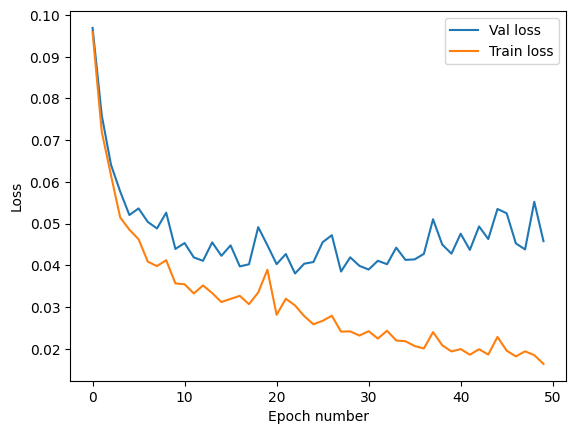

In [176]:
X_train, X_val, y_train, y_val = train_test_split(x_model, y_encoded, test_size=0.1, random_state=42)


classification_model = build_model([128,32],nn.ReLU())
new_model = deepcopy(classification_model)
print(new_model)
new_model = train_model(new_model, 
                               torch.from_numpy(X_train), 
                               y_train, 
                               torch.from_numpy(X_val), 
                               y_val,
                               optim.Adam(new_model.parameters(), lr=0.001),
                               nn.CrossEntropyLoss())

Divergence of train and val loss implies overfitting to training data, this can be fixed by L2 regularisation that punishes large weights, forcing the model to generalise.

Sequential(
  (0): Linear(in_features=512, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=6, bias=True)
)
Epoch 1, Validation Loss: 0.0953553281724453
Epoch 2, Validation Loss: 0.07223500544205308
Epoch 3, Validation Loss: 0.06528622886309257
Epoch 4, Validation Loss: 0.05578956620481152
Epoch 5, Validation Loss: 0.05282039625140337
Epoch 6, Validation Loss: 0.05379465924432644
Epoch 7, Validation Loss: 0.05180139209215458
Epoch 8, Validation Loss: 0.054752685487843476
Epoch 9, Validation Loss: 0.048598522069649056
Epoch 10, Validation Loss: 0.04757126877442575
Epoch 11, Validation Loss: 0.04628826921375898
Epoch 12, Validation Loss: 0.04700135052777254
Epoch 13, Validation Loss: 0.04647570742795674
Epoch 14, Validation Loss: 0.045759892503086194
Epoch 15, Validation Loss: 0.0503185207131677
Epoch 16, Validation Loss: 0.045439349523243994
Epoch 17, Validation Loss: 0.04543304

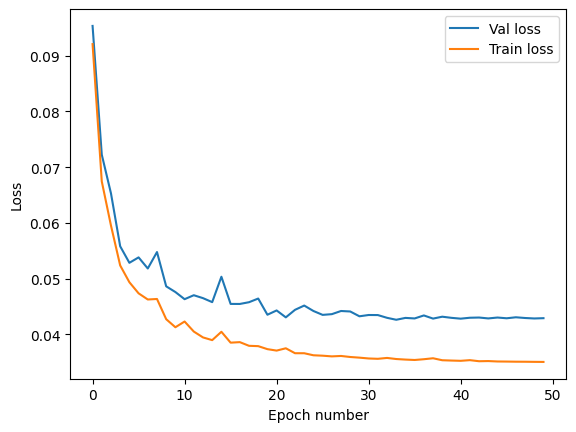

In [178]:
X_train, X_val, y_train, y_val = train_test_split(x_model, y_encoded, test_size=0.1, random_state=42)


classification_model = build_model([128,32],nn.ReLU())
new_model = deepcopy(classification_model)
print(new_model)
new_model = train_model(new_model, 
                               torch.from_numpy(X_train), 
                               y_train, 
                               torch.from_numpy(X_val), 
                               y_val,
                               optim.Adam(new_model.parameters(), lr=0.001, weight_decay=1e-4),
                               nn.CrossEntropyLoss())

This large difference between the validation and training loss implies the model is overfitting 

In [116]:
from sklearn.model_selection import ParameterGrid, GridSearchCV, KFold
def perform_hyperparameter_search(X_train, y_train, X_val, y_val):
    # Ensure to add whatever inputs you deem necessary to this function
    """
    Performs a hyper-parameter for fine-tuning the regressor implemented
    in the Regressor class.

    Arguments:
        Add whatever inputs you need.

    Returns:
        The function should return your optimised hyper-parameters.

    """

    #######################################################################
    #                       ** START OF YOUR CODE **
    #######################################################################
    parameter_grid = {
      
        'learning_rate': [0.01,0.001],
        'hidden_layer_size': [[256, 64],[128, 32],[128, 64]],
        'activation_fn': [torch.nn.ReLU(),torch.nn.Tanh()],
        'nb_epoch': [50]
    }
    best_loss = float('inf')
    best_params = None
    grid = ParameterGrid(parameter_grid)

   

    for parameters in grid:
        print(f"Testing parameters: {parameters}")
       
        if True:
            
            classification_model = build_model(parameters['hidden_layer_size'],parameters['activation_fn'])
            print(classification_model)
          
            classification_model, list_of_MSE_per_epoch, list_of_val = train_mode_MSE(classification_model, 
                torch.from_numpy(X_train), 
                y_train, 
                torch.from_numpy(X_val), 
                y_val,
                optim.Adam(classification_model.parameters(), lr=parameters['learning_rate'],weight_decay=1e-4),
                nn.CrossEntropyLoss(),
                num_epochs = parameters['nb_epoch'],
                plotting = False)

            min_loss = np.min(list_of_val)
            print(min_loss)
        # Update the best model if this one performs better
        if min_loss < best_loss:
            best_loss = min_loss
            best_params = parameters
            

    print("Best Parameters:", best_params)
    print("Lowest loss:", best_loss)
    return best_params


In [117]:
print(perform_hyperparameter_search(X_train, y_train, X_val, y_val))


Testing parameters: {'activation_fn': ReLU(), 'hidden_layer_size': [256, 64], 'learning_rate': 0.01, 'nb_epoch': 50}
Sequential(
  (0): Linear(in_features=512, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=6, bias=True)
)
Epoch 1, Validation Loss: 0.06390118792366523
Epoch 2, Validation Loss: 0.05453498354360748
Epoch 3, Validation Loss: 0.046519654570147395
Epoch 4, Validation Loss: 0.0639741830348682
Epoch 5, Validation Loss: 0.04562979340195083
Epoch 6, Validation Loss: 0.05368024581828369
Epoch 7, Validation Loss: 0.045519654401757106
Epoch 8, Validation Loss: 0.04406200582161546
Epoch 9, Validation Loss: 0.04336822889028834
Epoch 10, Validation Loss: 0.04796963667747779
Epoch 11, Validation Loss: 0.0391704700439452
Epoch 12, Validation Loss: 0.04422126603850092
Epoch 13, Validation Loss: 0.04040039587730112
Epoch 14, Validation Loss: 0.04073790834249499
Epoch 15, Valida

Update model parameters to the optimal ones found by the hyperparameter search:

Epoch 1, Validation Loss: 0.054909359341344006
Epoch 2, Validation Loss: 0.07645157849989258
Epoch 3, Validation Loss: 0.060087780239812746
Epoch 4, Validation Loss: 0.058283595457816355
Epoch 5, Validation Loss: 0.05190472355864655
Epoch 6, Validation Loss: 0.06892438482743903
Epoch 7, Validation Loss: 0.04708668636158109
Epoch 8, Validation Loss: 0.04303902948203568
Epoch 9, Validation Loss: 0.04168659726229425
Epoch 10, Validation Loss: 0.041409301231257044
Epoch 11, Validation Loss: 0.04323084998983317
Epoch 12, Validation Loss: 0.043229178086711235
Epoch 13, Validation Loss: 0.04148581756789309
Epoch 14, Validation Loss: 0.03789892136298407
Epoch 15, Validation Loss: 0.03398031940182241
Epoch 16, Validation Loss: 0.03629742182182291
Epoch 17, Validation Loss: 0.0370820800263363
Epoch 18, Validation Loss: 0.033958968751204126
Epoch 19, Validation Loss: 0.0404844584230047
Epoch 20, Validation Loss: 0.03611960988312673
Epoch 21, Validation Loss: 0.037978696099554114
Epoch 22, Validat

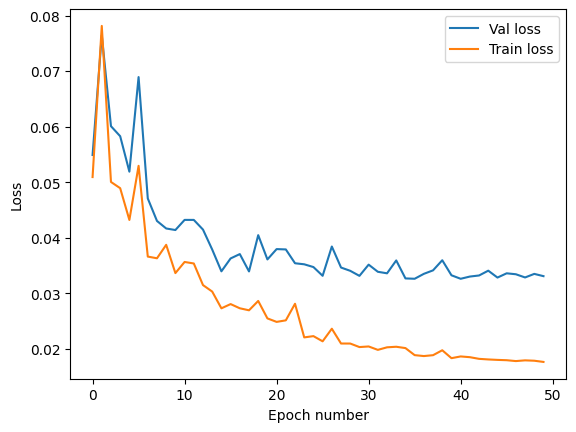

In [188]:

X_train, X_val, y_train, y_val = train_test_split(x_model, y_encoded, test_size=0.1, random_state=42)
classification_model = build_model([256,64],nn.ReLU())
new_model = deepcopy(classification_model)
# dont need val set as this is our final model, so train on whole train set
new_model = train_model(new_model, 
                               torch.from_numpy(X_train), 
                               y_train, 
                               torch.from_numpy(X_val), 
                               y_val,
                               optim.Adam(new_model.parameters(), lr=0.01, weight_decay=1e-4),
                               nn.CrossEntropyLoss())

In [189]:
def get_evaluations(name_data_set, y_true, y_pred) -> dict:
  accuracy = accuracy_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred, average='macro')
  f1 = f1_score(y_true, y_pred, average='macro')
  recall = recall_score(y_true, y_pred, average='macro')
  precision_l = precision_score(y_true, y_pred, average=None, labels=['ERYTHROID', 'STROMA', 'MYELOID', 'LYMPHOID', 'PROGENITOR', 'MK'])[3]
  f1_l = f1_score(y_true, y_pred, average=None, labels=['ERYTHROID', 'STROMA', 'MYELOID', 'LYMPHOID', 'PROGENITOR', 'MK'])[3]
  recall_l = recall_score(y_true, y_pred, average=None, labels=['ERYTHROID', 'STROMA', 'MYELOID', 'LYMPHOID', 'PROGENITOR', 'MK'])[3]
  print(f"{name_data_set} accuracy: {(accuracy*100):.1f}%")
  print(f"{name_data_set} precision: {(precision*100):.1f}%")
  print(f"{name_data_set} f1: {(f1*100):.1f}%")
  print(f"{name_data_set} recall: {(recall*100):.1f}%")
  print(f"Lymphoid precision: {(precision_l*100):.1f}%")
  print(f"Lymphoid f1: {(f1_l*100):.1f}%")
  print(f"Lymphoid recall: {(recall_l*100):.1f}%")
  return {
      "accuracy": accuracy,
      "precision": precision,
      "f1": f1,
      "recall": recall,
  }

In [190]:

ds = load_dataset("helical-ai/yolksac_human",trust_remote_code=True, split="train[70%:]",download_mode="reuse_cache_if_exists")
observation_columns = [obs for obs in list(ds.features.keys()) if not obs == 'raw_counts']
obs_data = pd.DataFrame(ds.select_columns(observation_columns).data.to_pandas(),columns=observation_columns)
lil = lil_matrix((len(ds),ds[0]['size']))
lil.data = np.array(ds['raw_counts'],dtype="object")
lil.rows = np.array(ds['rows'],dtype="object")
adata_unseen = ad.AnnData(lil.tocsr(),obs=obs_data)
adata_unseen.var_names = ds.features['raw_counts'].id.split(",")
adata_unseen.var['gene_name'] = adata_unseen.var_names.str.upper()

Generating test split: 100%|██████████| 6336/6336 [00:04<00:00, 1561.69 examples/s]


In [ ]:
data_unseen = scgpt.process_data(adata_unseen, gene_names="gene_name")
x_unseen = scgpt.get_embeddings(data_unseen)
x_model_unseen, x_model_dropped_unseen = knockout_genes(adata_unseen,scgpt,knockout)
x, x_model_stroma = knockout_genes(adata_unseen,scgpt,stroma_genes)
predictions_nn_unseen = new_model(torch.Tensor(x_unseen))
pred_x_model = new_model(torch.Tensor(x_model_unseen))
pred_x_model_dropped = new_model(torch.Tensor(x_model_dropped_unseen))



INFO:helical.models.scgpt.model:Filtering out 11163 genes to a total of 26155 genes with an id in the scGPT vocabulary.
INFO:helical.models.scgpt.model:Inference started:
Embedding cells: 100%|██████████| 153/153 [01:41<00:00,  1.51it/s]
INFO:helical.models.scgpt.model:Filtering out 11163 genes to a total of 26155 genes with an id in the scGPT vocabulary.
INFO:helical.models.scgpt.model:Inference started:


  (0, 11)	1.0
  (0, 23)	1.0
  (0, 80)	1.0
  (0, 83)	1.0
  (0, 98)	1.0
  (0, 113)	1.0
  (0, 1934)	1.0
  (0, 3365)	1.0
  (0, 4670)	27.0
  (0, 5864)	1.0
  (0, 5881)	19.0
  (0, 5917)	1.0
  (0, 5965)	1.0
  (0, 6053)	1.0
  (0, 6062)	2.0
  (0, 6089)	1.0
  (0, 6090)	5.0
  (0, 6224)	2.0
  (0, 6239)	1.0
  (0, 6267)	11.0
  (0, 6296)	1.0
  (0, 6327)	1.0
  (0, 7146)	1.0
  (0, 7544)	1.0
  (0, 8379)	2.0
  :	:
  (40, 35622)	1.0
  (40, 35626)	1.0
  (40, 35675)	1.0
  (40, 35686)	2.0
  (40, 35690)	1.0
  (40, 35694)	2.0
  (40, 35696)	1.0
  (40, 35807)	1.0
  (40, 35817)	2.0
  (40, 35870)	1.0
  (40, 35881)	1.0
  (40, 35882)	1.0
  (40, 35917)	1.0
  (40, 35947)	1.0
  (40, 35961)	9.0
  (40, 36043)	1.0
  (40, 36276)	1.0
  (40, 36288)	1.0
  (40, 36586)	1.0
  (40, 36595)	1.0
  (40, 37190)	1.0
  (40, 37210)	1.0
  (40, 37241)	1.0
  (40, 37243)	1.0
  (40, 37249)	1.0


Embedding cells: 100%|██████████| 153/153 [01:46<00:00,  1.44it/s]
INFO:helical.models.scgpt.model:Filtering out 11163 genes to a total of 26155 genes with an id in the scGPT vocabulary.
INFO:helical.models.scgpt.model:Inference started:


[17219, 17263, 17264]


Embedding cells: 100%|██████████| 153/153 [01:46<00:00,  1.43it/s]


In [ ]:
x, x_model_stroma = knockout_genes(adata_unseen,scgpt,stroma_genes)
pred_x_model_stroma = new_model(torch.Tensor(x_model_stroma))
y_model_stroma_pred_unseen = [id2type[prediction] for prediction in np.array(torch.argmax(pred_x_model_stroma, dim=1))]
y_true_unseen = np.array(adata_unseen.obs["LVL1"].tolist())
results = get_evaluations("Evaluation set", y_true_unseen, y_model_stroma_pred_unseen)

INFO:helical.models.scgpt.model:Filtering out 11163 genes to a total of 26155 genes with an id in the scGPT vocabulary.
INFO:helical.models.scgpt.model:Inference started:


  (0, 11)	1.0
  (0, 23)	1.0
  (0, 80)	1.0
  (0, 83)	1.0
  (0, 98)	1.0
  (0, 113)	1.0
  (0, 1934)	1.0
  (0, 3365)	1.0
  (0, 4670)	27.0
  (0, 5864)	1.0
  (0, 5881)	19.0
  (0, 5917)	1.0
  (0, 5965)	1.0
  (0, 6053)	1.0
  (0, 6062)	2.0
  (0, 6089)	1.0
  (0, 6090)	5.0
  (0, 6224)	2.0
  (0, 6239)	1.0
  (0, 6267)	11.0
  (0, 6296)	1.0
  (0, 6327)	1.0
  (0, 7146)	1.0
  (0, 7544)	1.0
  (0, 8379)	2.0
  :	:
  (40, 35622)	1.0
  (40, 35626)	1.0
  (40, 35675)	1.0
  (40, 35686)	2.0
  (40, 35690)	1.0
  (40, 35694)	2.0
  (40, 35696)	1.0
  (40, 35807)	1.0
  (40, 35817)	2.0
  (40, 35870)	1.0
  (40, 35881)	1.0
  (40, 35882)	1.0
  (40, 35917)	1.0
  (40, 35947)	1.0
  (40, 35961)	9.0
  (40, 36043)	1.0
  (40, 36276)	1.0
  (40, 36288)	1.0
  (40, 36586)	1.0
  (40, 36595)	1.0
  (40, 37190)	1.0
  (40, 37210)	1.0
  (40, 37241)	1.0
  (40, 37243)	1.0
  (40, 37249)	1.0


Embedding cells: 100%|██████████| 153/153 [01:05<00:00,  2.35it/s]
INFO:helical.models.scgpt.model:Filtering out 11163 genes to a total of 26155 genes with an id in the scGPT vocabulary.
INFO:helical.models.scgpt.model:Inference started:


[17263, 17264]


Embedding cells: 100%|██████████| 153/153 [01:13<00:00,  2.07it/s]


Evaluation set accuracy: 99.2%
Evaluation set precision: 90.0%
Evaluation set f1: 87.2%
Evaluation set recall: 85.1%
Lymphoid precision: 76.5%
Lymphoid f1: 66.7%
Lymphoid recall: 59.1%


In [194]:
y_true_unseen = np.array(adata_unseen.obs["LVL1"].tolist())
y_pred_unseen = [id2type[prediction] for prediction in np.array(torch.argmax(predictions_nn_unseen, dim=1))]

y_model_pred_unseen = [id2type[prediction] for prediction in np.array(torch.argmax(pred_x_model, dim=1))]

y_model_dropped_pred_unseen = [id2type[prediction] for prediction in np.array(torch.argmax(pred_x_model_dropped, dim=1))]

print(precision_score(y_true_unseen, y_pred_unseen, average=None,labels=['ERYTHROID', 'STROMA', 'MYELOID', 'LYMPHOID', 'PROGENITOR', 'MK']))
results = get_evaluations("Evaluation set", y_true_unseen, y_pred_unseen)
results = get_evaluations("Evaluation set", y_true_unseen, y_model_pred_unseen)
results = get_evaluations("Evaluation set", y_true_unseen, y_model_dropped_pred_unseen)

[0.99768519 0.99707174 0.97862454 0.90909091 0.61290323 0.93478261]
Evaluation set accuracy: 99.3%
Evaluation set precision: 90.5%
Evaluation set f1: 86.6%
Evaluation set recall: 85.3%
Lymphoid precision: 90.9%
Lymphoid f1: 60.6%
Lymphoid recall: 45.5%
Evaluation set accuracy: 99.3%
Evaluation set precision: 90.5%
Evaluation set f1: 86.6%
Evaluation set recall: 85.3%
Lymphoid precision: 90.9%
Lymphoid f1: 60.6%
Lymphoid recall: 45.5%
Evaluation set accuracy: 99.2%
Evaluation set precision: 86.7%
Evaluation set f1: 83.4%
Evaluation set recall: 81.5%
Lymphoid precision: 66.7%
Lymphoid f1: 47.1%
Lymphoid recall: 36.4%


['ERYTHROID' 'LYMPHOID' 'MK' 'MYELOID' 'PROGENITOR' 'STROMA']


<Axes: >

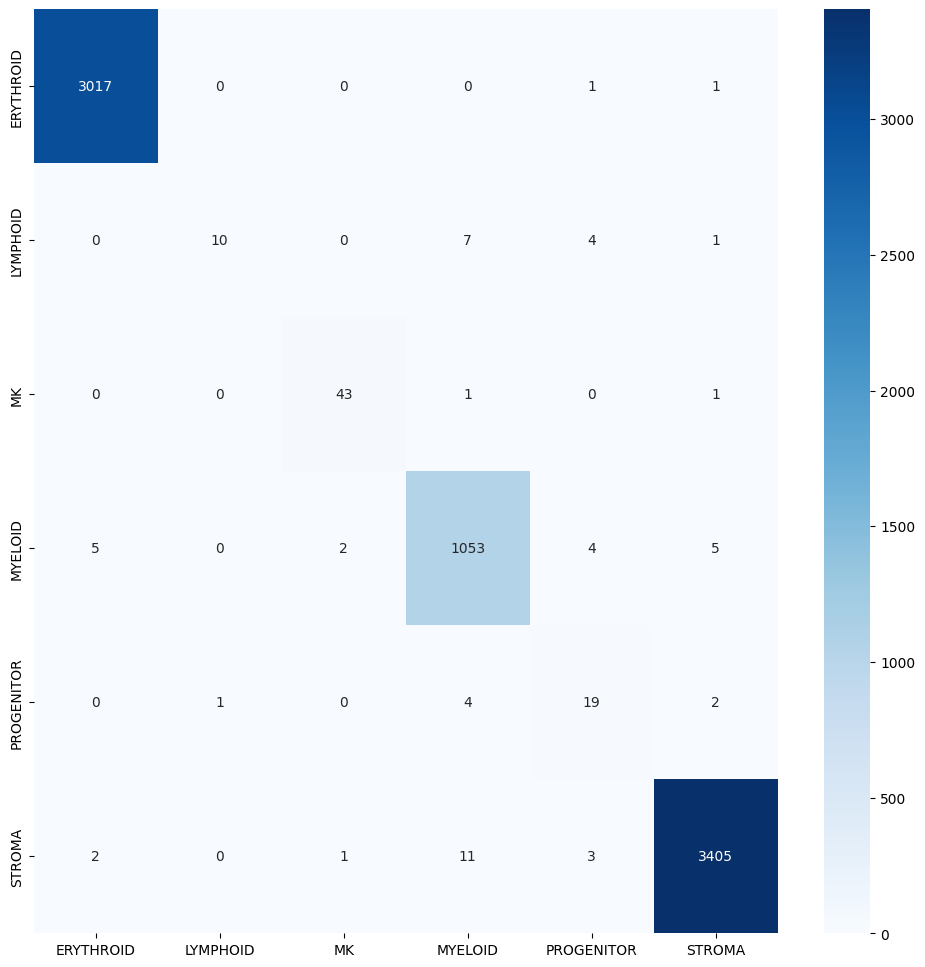

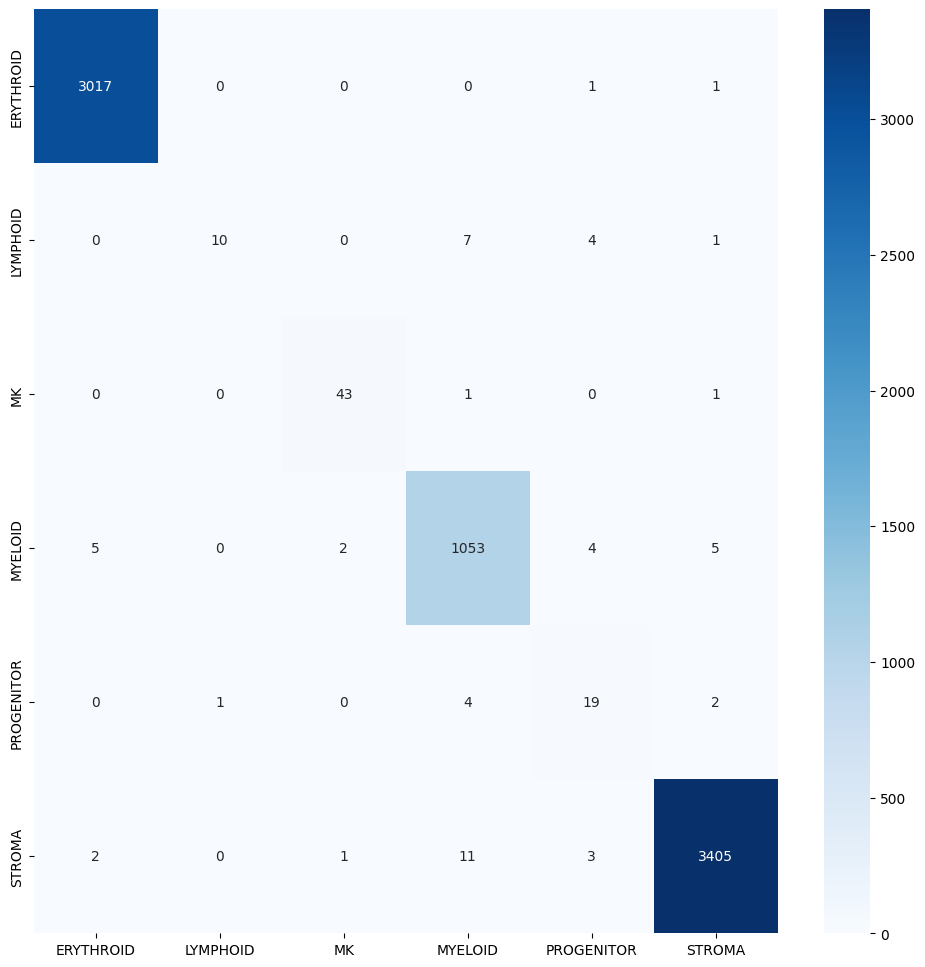

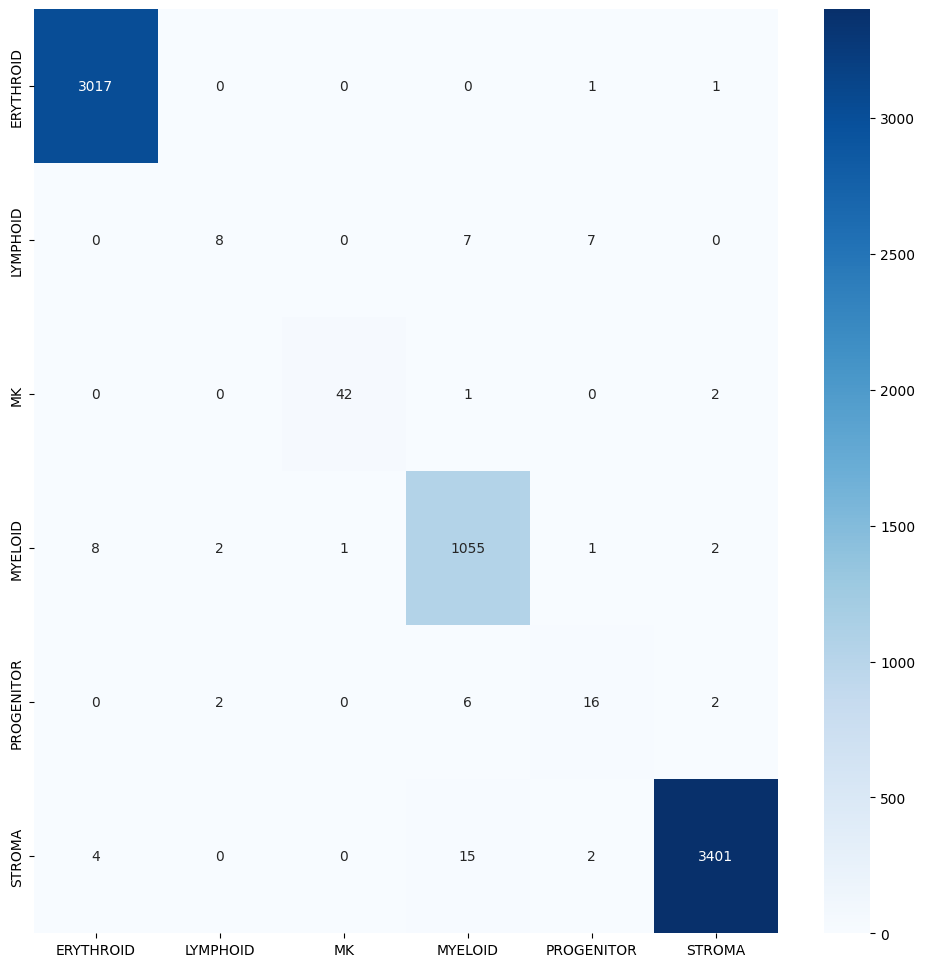

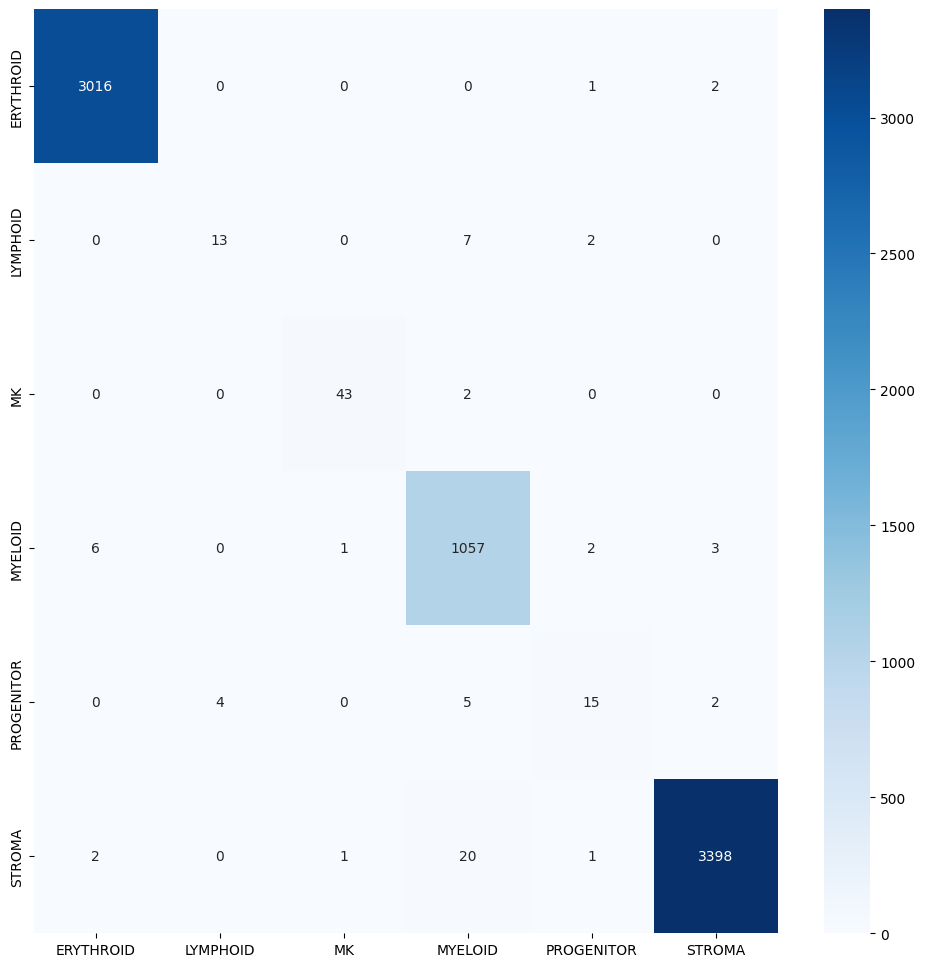

In [233]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
print(np.unique(y_true_unseen))
set_predicted_cell_types = list(adata_unseen.obs["LVL1"].unique())
for i in set(y_pred_unseen):
    if i not in set_predicted_cell_types:
        set_predicted_cell_types.remove(i)
# ground truth on y axis, predicted on x axis
cm = confusion_matrix(y_true_unseen, y_pred_unseen)
cm = pd.DataFrame(cm, index=np.unique(y_true_unseen)[:cm.shape[0]], columns=np.unique(y_true_unseen)[:cm.shape[1]])
plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot=True, fmt=".0f", cmap="Blues")
cm = confusion_matrix(y_true_unseen, y_model_pred_unseen)
cm = pd.DataFrame(cm, index=np.unique(y_true_unseen)[:cm.shape[0]], columns=np.unique(y_true_unseen)[:cm.shape[1]])
plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot=True, fmt=".0f", cmap="Blues")
cm = confusion_matrix(y_true_unseen, y_model_dropped_pred_unseen)
cm = pd.DataFrame(cm, index=np.unique(y_true_unseen)[:cm.shape[0]], columns=np.unique(y_true_unseen)[:cm.shape[1]])
plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot=True, fmt=".0f", cmap="Blues")
cm = confusion_matrix(y_true_unseen, y_model_stroma_pred_unseen)
cm = pd.DataFrame(cm, index=np.unique(y_true_unseen)[:cm.shape[0]], columns=np.unique(y_true_unseen)[:cm.shape[1]])
plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot=True, fmt=".0f", cmap="Blues")
#results = get_evaluations("Evaluation set", y_true_unseen, y_model_stroma_pred_unseen)

Now compare to model trained on genes present in all lymphoid examples dropped:

Epoch 1, Validation Loss: 0.0786311174921978
Epoch 2, Validation Loss: 0.05947221378580882
Epoch 3, Validation Loss: 0.06417746462214452
Epoch 4, Validation Loss: 0.0430100319477228
Epoch 5, Validation Loss: 0.044182764617009804
Epoch 6, Validation Loss: 0.04006202263721766
Epoch 7, Validation Loss: 0.041228298867981024
Epoch 8, Validation Loss: 0.042423536302521825
Epoch 9, Validation Loss: 0.04262343170837714
Epoch 10, Validation Loss: 0.0348322383271387
Epoch 11, Validation Loss: 0.05131335882470012
Epoch 12, Validation Loss: 0.0395796918310225
Epoch 13, Validation Loss: 0.045629551670012564
Epoch 14, Validation Loss: 0.0333982699801429
Epoch 15, Validation Loss: 0.027983043024925373
Epoch 16, Validation Loss: 0.03278120518482935
Epoch 17, Validation Loss: 0.035982361126046344
Epoch 18, Validation Loss: 0.03636879485566169
Epoch 19, Validation Loss: 0.028819262685898978
Epoch 20, Validation Loss: 0.02933098310425591
Epoch 21, Validation Loss: 0.0335956884888359
Epoch 22, Validation 

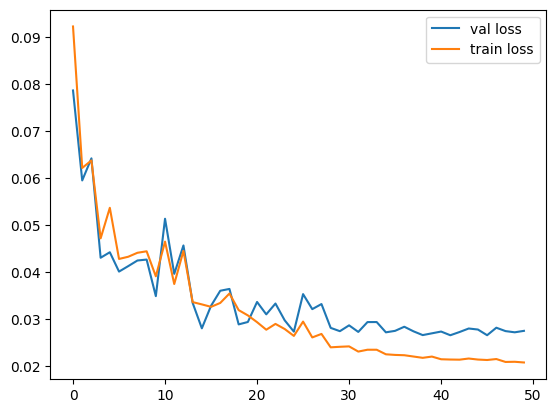

In [134]:
X_train, X_val, y_train, y_val = train_test_split(x_model_dropped, y_encoded, test_size=0.1, random_state=42)
classification_model = build_model([256,64],nn.ReLU())
new_model = deepcopy(classification_model)
# dont need val set as this is our final model, so train on whole train set
new_model_lym = train_model(new_model, 
                               torch.from_numpy(X_train), 
                               y_train, 
                               torch.from_numpy(X_val), 
                               y_val,
                               optim.Adam(new_model.parameters(), lr=0.01, weight_decay=1e-4),
                               nn.CrossEntropyLoss())

In [135]:

ds = load_dataset("helical-ai/yolksac_human",trust_remote_code=True, split="train[70%:]",download_mode="reuse_cache_if_exists")
observation_columns = [obs for obs in list(ds.features.keys()) if not obs == 'raw_counts']
obs_data = pd.DataFrame(ds.select_columns(observation_columns).data.to_pandas(),columns=observation_columns)
lil = lil_matrix((len(ds),ds[0]['size']))
lil.data = np.array(ds['raw_counts'],dtype="object")
lil.rows = np.array(ds['rows'],dtype="object")
adata_unseen = ad.AnnData(lil.tocsr(),obs=obs_data)
adata_unseen.var_names = ds.features['raw_counts'].id.split(",")
adata_unseen.var['gene_name'] = adata_unseen.var_names.str.upper()

Generating test split: 100%|██████████| 6336/6336 [00:03<00:00, 1792.77 examples/s]


In [136]:
data_unseen = scgpt.process_data(adata_unseen, gene_names="gene_name")
x_unseen = scgpt.get_embeddings(data_unseen)
predictions_nn_unseen = new_model_lym(torch.Tensor(x_unseen))
y_true_unseen = np.array(adata_unseen.obs["LVL1"].tolist())
y_pred_unseen = [id2type[prediction] for prediction in np.array(torch.argmax(predictions_nn_unseen, dim=1))]

print(precision_score(y_true_unseen, y_pred_unseen, average=None,labels=['ERYTHROID', 'STROMA', 'MYELOID', 'LYMPHOID', 'PROGENITOR', 'MK']))
results = get_evaluations("Evaluation set", y_true_unseen, y_pred_unseen)

INFO:helical.models.scgpt.model:Filtering out 11163 genes to a total of 26155 genes with an id in the scGPT vocabulary.
INFO:helical.models.scgpt.model:Inference started:
Embedding cells: 100%|██████████| 153/153 [01:19<00:00,  1.93it/s]


[0.99834437 0.99706573 0.97235023 0.875      0.55555556 0.93478261]
Evaluation set accuracy: 99.1%
Evaluation set precision: 88.9%
Evaluation set f1: 83.8%
Evaluation set recall: 83.7%
Lymphoid precision: 87.5%
Lymphoid f1: 46.7%
Lymphoid recall: 31.8%


<Axes: >

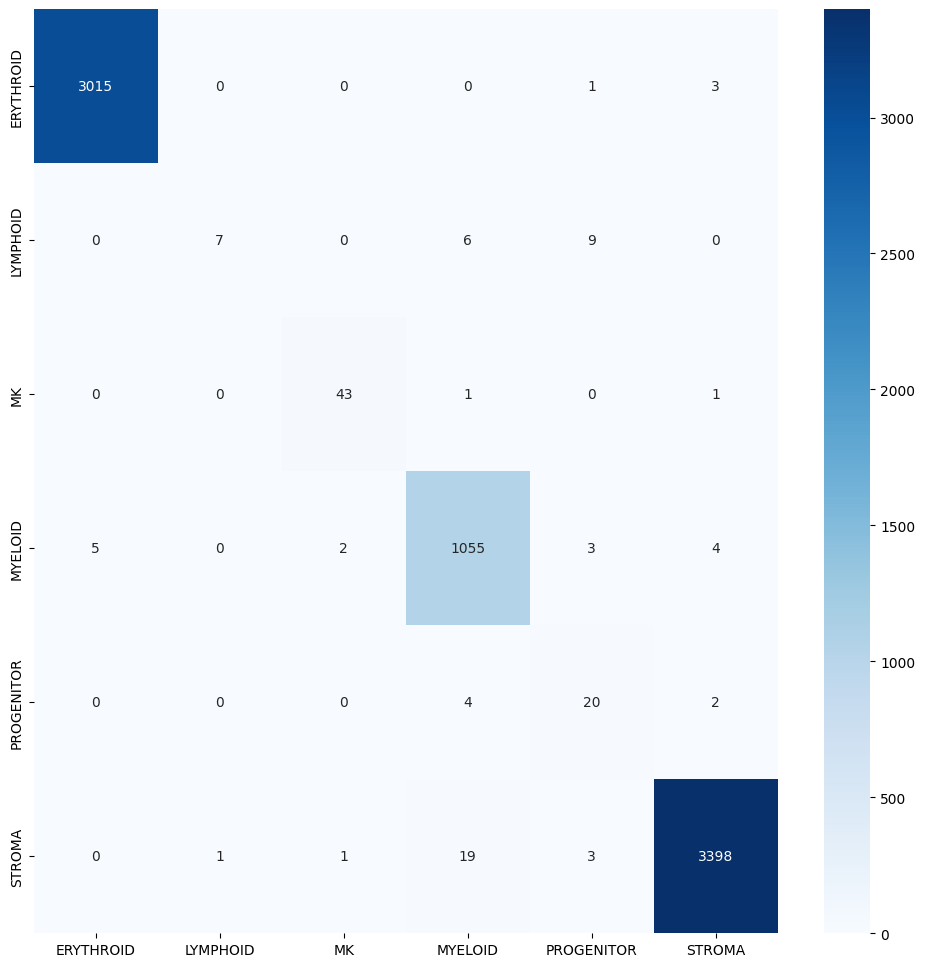

In [137]:
cm = confusion_matrix(y_true_unseen, y_pred_unseen)
#cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
#cm = pd.DataFrame(cm, index=set_predicted_cell_types[:cm.shape[0]], columns=set_predicted_cell_types[:cm.shape[1]])
cm = pd.DataFrame(cm, index=np.unique(y_true_unseen)[:cm.shape[0]], columns=np.unique(y_true_unseen)[:cm.shape[1]])
plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot=True, fmt=".0f", cmap="Blues")

High recall, lower precision on Lymphoid cells

Evaluation set accuracy: 99.2%
Evaluation set precision: 88.9%
Evaluation set f1: 85.0%
Evaluation set recall: 84.1%
Lymphoid precision: 80.0%
Lymphoid f1: 50.0%
Lymphoid recall: 36.4%  for no knockout


Evaluation set accuracy: 99.1%
Evaluation set precision: 88.9%
Evaluation set f1: 83.8%
Evaluation set recall: 83.7%
Lymphoid precision: 87.5%
Lymphoid f1: 46.7%
Lymphoid recall: 31.8% for knockout

Extremely similar performance between models with knockout and no knockout, so the model generalises well beyond these genes that are present in all of the lymphoid examples.

In [153]:
stroma_data = adata[adata.obs["LVL1"]==labels[0]]
print(labels)
# store frequency of genes in a list where index corresponds to gene_index shown in row
gene_list = np.zeros(len(adata.var))
for x in stroma_data.obs['rows']:
    for gene in x:
        gene_list[gene] += 1
print(max(gene_list))
print(np.where(gene_list>7000)[0])
#knockout = np.where(gene_list==29.0)[0]
stroma_genes = np.where(gene_list>5025)[0]
print(len(stroma_genes))

['STROMA' 'ERYTHROID' 'MYELOID' 'MK' 'PROGENITOR' 'LYMPHOID']
7715.0
[ 5881  5883 14731 16226 16227 16379 17196 22522 22524 22525 22526 22527
 22530 22531 22532 22612 31320 31323 31324 31325 31327 31333 31341 31346
 31347 31349 31351 31352 31361 31364 31368 31372 31374 31376 31377 31399
 31401 31402 31403 31406 31407 31409 31412 31413 31416 31417 31419 31421
 31422 31423 31441 31442 34690 34897 35328]
159


how low can the number of examples of stroma,erythroid and myeloid go before the performance degrades below the bottleneck due to small numbers of MK progenitor and lymphoid cells

Droppout, 50,90,99 percent of genes and see how it affects metrics

In [154]:
x_model_s, x_model_stroma_dropped = knockout_genes(adata,scgpt,stroma_genes)

INFO:helical.models.scgpt.model:Filtering out 11163 genes to a total of 26155 genes with an id in the scGPT vocabulary.
INFO:helical.models.scgpt.model:Inference started:


  (0, 3)	2.0
  (0, 26)	1.0
  (0, 41)	3.0
  (0, 55)	1.0
  (0, 67)	2.0
  (0, 68)	4.0
  (0, 69)	2.0
  (0, 72)	2.0
  (0, 91)	1.0
  (0, 98)	2.0
  (0, 110)	1.0
  (0, 119)	1.0
  (0, 120)	1.0
  (0, 129)	1.0
  (0, 188)	1.0
  (0, 348)	2.0
  (0, 437)	1.0
  (0, 488)	1.0
  (0, 497)	1.0
  (0, 519)	1.0
  (0, 634)	1.0
  (0, 904)	1.0
  (0, 957)	1.0
  (0, 1311)	1.0
  (0, 1572)	1.0
  :	:
  (40, 35704)	1.0
  (40, 35730)	1.0
  (40, 35743)	1.0
  (40, 35798)	1.0
  (40, 35807)	1.0
  (40, 35812)	1.0
  (40, 35850)	1.0
  (40, 35860)	1.0
  (40, 35888)	1.0
  (40, 36098)	1.0
  (40, 36156)	1.0
  (40, 36181)	1.0
  (40, 36276)	1.0
  (40, 36280)	1.0
  (40, 36319)	2.0
  (40, 36506)	1.0
  (40, 36557)	1.0
  (40, 36586)	1.0
  (40, 36588)	1.0
  (40, 36657)	1.0
  (40, 36905)	1.0
  (40, 37024)	1.0
  (40, 37054)	1.0
  (40, 37243)	1.0
  (40, 37306)	1.0


Embedding cells: 100%|██████████| 330/330 [02:59<00:00,  1.84it/s]
INFO:helical.models.scgpt.model:Filtering out 11163 genes to a total of 26155 genes with an id in the scGPT vocabulary.
INFO:helical.models.scgpt.model:Inference started:


[17263, 17264]


Embedding cells: 100%|██████████| 330/330 [03:29<00:00,  1.57it/s]


In [160]:
def get_evaluations_weighted(name_data_set, y_true, y_pred) -> dict:
  accuracy = accuracy_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred, average='weighted')
  f1 = f1_score(y_true, y_pred, average='weighted')
  recall = recall_score(y_true, y_pred, average='weighted')
  precision_l = precision_score(y_true, y_pred, average=None, labels=['ERYTHROID', 'STROMA', 'MYELOID', 'LYMPHOID', 'PROGENITOR', 'MK'])[1]
  f1_l = f1_score(y_true, y_pred, average=None, labels=['ERYTHROID', 'STROMA', 'MYELOID', 'LYMPHOID', 'PROGENITOR', 'MK'])[1]
  recall_l = recall_score(y_true, y_pred, average=None, labels=['ERYTHROID', 'STROMA', 'MYELOID', 'LYMPHOID', 'PROGENITOR', 'MK'])[1]
  print(f"{name_data_set} accuracy: {(accuracy*100):.1f}%")
  print(f"{name_data_set} precision: {(precision*100):.1f}%")
  print(f"{name_data_set} f1: {(f1*100):.1f}%")
  print(f"{name_data_set} recall: {(recall*100):.1f}%")
  print(f"Stroma precision: {(precision_l*100):.1f}%")
  print(f"Stroma f1: {(f1_l*100):.1f}%")
  print(f"Stroma recall: {(recall_l*100):.1f}%")
  return {
      "accuracy": accuracy,
      "precision": precision,
      "f1": f1,
      "recall": recall,
  }

results = get_evaluations_weighted("Evaluation set", y_true_unseen_stroma, y_pred_unseen_stroma)

Evaluation set accuracy: 99.3%
Evaluation set precision: 99.3%
Evaluation set f1: 99.2%
Evaluation set recall: 99.3%
Stroma precision: 99.7%
Stroma f1: 99.7%
Stroma recall: 99.6%


In [164]:
print(np.sum([stroma_genes[i] in knockout for i in range(len(stroma_genes))]))

117


117 of the 159 genes are the same between the stroma and lymphoid knockout sets, implying that the 42 genes present in the stroma set that are not present in the knockout set are important for creating inferences about whether a cell is a lymphoid cell, maybe they are genes that are most often present in lymphoid cells and stroma cells but not the progenitor cells, which the model finds hard to distinguish from lymphoid cells.